# Image classification with Bilinear Model

## Project Overview

I'm using bilinear model for flood detection.

This project can be used as a complete guide to EDA and machine learning technique for sentence classification tasks accompanied with advice for practioners. It will cover:

+ Craw data
+ Preprocessing data image
+ Tranfer learning with EfficientNetB4
+ Building bilinear model with 2 model EfficientNetB4
    +trainning with freezing base model weight
    +trainning with unfreezing base model weight
+ compare result

## Problem statement

I try to improve preformance of EfficientNetB4. I using 2 EfficientNetB4 model to improve. This is called Bilinear Model. 

## Dataset

find dataset in this link : https://www.kaggle.com/competitions/spr22-AIG201m-DPL301m

this dataset 2 file:
+ devset_images_gt.csv : data contain label
+ devset_images_metadata.json : metadata file, using to crawdata

## Metrics
In this project, we use performance metrics as precision, recall, and F1-Score. A binary classifier can be viewed as classifying instances as positive or negative:

+ Positive: The instance is classified as a member of the class the classifier is trying to identify. For example, a classifier looking for cat photos would classify photos with cats as positive (when correct).

+ Negative: The instance is classified as not being a member of the class we are trying to identify. For example, a classifier looking for cat photos should classify photos with dogs (and no cats) as negative.

The basis of precision, recall, and F1-Score comes from the concepts of True Positive, True Negative, False Positive, and False Negative

+ Precision is a measure of how many of the positive predictions made are correc

+ Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data. It is sometimes also referred to as Sensitivity.

F1-Score is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean.

## Craw data

<strong>If craw data spend so much time</strong>. You can pass this step and download data in here:  https://drive.google.com/drive/folders/1CDaWl834KMQY_yfiiiG_-lLx4YDzVrof?usp=sharing

#### read json file to dataframe

In [ ]:
import json
import pandas as pd

fname = 'devset_images_metadata.json'
str_data = open(fname).read()
json_data = json.loads(str_data)
lstImageUrl = []
lstImageID =[]
for i in json_data['images']:
    lstImageUrl.append(i["image_url"])
    lstImageID.append(i["image_id"])
dict = {'image_url' : lstImageUrl,"ID": lstImageID}
df = pd.DataFrame(dict)
df.head()

#### download image

In [ ]:
import json
import pandas as pd
import requests # request img from web
import shutil
from bs4 import BeautifulSoup
from urllib.request import urlopen
for index, row in df.iterrows():
    try:
        htmldata = urlopen(url = row["image_url"])
        soup = BeautifulSoup(htmldata, 'html.parser')
        images = soup.find_all('img')
        print(images[0]['src'])
        url = "https:"+images[0]['src']
        file_name = row["ID"]+".jpg"
        res = requests.get(url, stream = True)
        if res.status_code == 200:
            with open(file_name,'wb') as f:
                shutil.copyfileobj(res.raw, f)
            print('Image sucessfully Downloaded: ',file_name)
        else:
            print('Image Couldn\'t be retrieved')
    except:

        print(row["image_url"]+" not found!!!")

# Preprocessing data image

read label file

In [4]:
import pandas as pd
df = pd.read_csv("devset_images_gt.csv")
df["id"].astype(str)
df =df[["id","label"]]
df

,id,label
0,3519864665,0
1,4896119055,0
2,3468473862,0
3,4120853942,0
4,4436083254,0
...,...,...
5275,8119782888,0
5276,6093294301,1
5277,6791185487,0
5278,9144682941,0


load data from image, dataframe to numpy matrix

In [6]:
import cv2 
X=[]
Y=[]
for index, row in df.iterrows():
#     image_name = row["imageID"]
    try:
        img= cv2.imread("devset_images/"+str(row["id"])+".jpg")
        img= cv2.resize(img, (224,224))
        X.append(img)
        Y.append(row["label"])
    except:
        print("cant found"+str(row["id"]))

cant found3458255758
cant found5968047189
cant found4355060977
cant found9892658854
cant found8238634118
cant found7370874908
cant found12175187445
cant found3246368752
cant found2583620603
cant found9740979005
cant found4421805350
cant found8334177117
cant found6627602249
cant found4206386916
cant found8090836475


In [7]:
import numpy as np
X= np.array(X)
Y= np.array(Y)
print(X.shape)
print(Y.shape)

(5265, 224, 224, 3)
(5265,)


show some image

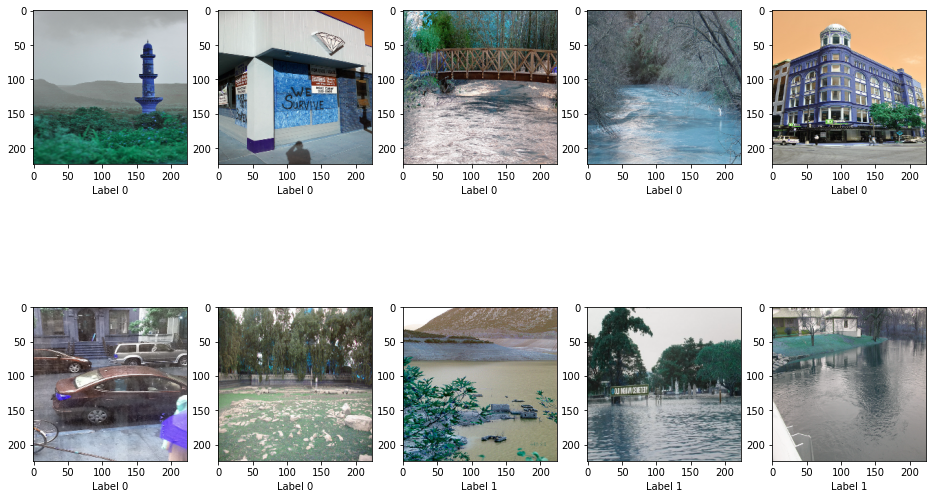

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel("Label " + str(Y[i]))
plt.show()

Split train and test set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.3, random_state=28)

## Tranfer learning with EfficientNetB4

In [10]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [11]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
IMG_SIZE = 224
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4,ResNet101V2
from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.resnet_v2 import preprocess_input
def build_model(num_classes=1):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)
    x = img_augmentation(x)
    model = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(1024, activation="relu", name="relu")(x)

    top_dropout_rate = 0.2

    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    x = layers.Dense(128, activation="relu", name="relu_2")(x)

    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy',f1]
    )
    return model

In [13]:
model_EfficientNet = build_model(num_classes=1)

71696384/71686520 [==============================] - 1s 0us/step


In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(mode='auto', filepath='./dgt301-{epoch:03d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                     monitor='val_loss',  
                     save_weights_only='True', 
                     period=1,
                     verbose=1,
                     save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=6,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

In [16]:
history = model_EfficientNet.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint,early_stopping,reduce_learning_rate]
)

Epoch 1/20
116/116 [==============================] - ETA: 0s - loss: 0.8670 - accuracy: 0.6437 - f1: 0.1242
Epoch 1: val_loss improved from inf to 0.55147, saving model to ./dgt301-001_loss-0.8670_val_loss-0.5515.h5
116/116 [==============================] - 56s 258ms/step - loss: 0.8670 - accuracy: 0.6437 - f1: 0.1242 - val_loss: 0.5515 - val_accuracy: 0.8158 - val_f1: 0.7696 - lr: 0.0100
Epoch 2/20
115/116 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.7937 - f1: 0.7214
Epoch 2: val_loss improved from 0.55147 to 0.40592, saving model to ./dgt301-002_loss-0.4797_val_loss-0.4059.h5
116/116 [==============================] - 26s 224ms/step - loss: 0.4797 - accuracy: 0.7938 - f1: 0.7220 - val_loss: 0.4059 - val_accuracy: 0.8525 - val_f1: 0.7960 - lr: 0.0100
Epoch 3/20
115/116 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8035 - f1: 0.7442
Epoch 3: val_loss improved from 0.40592 to 0.37654, saving model to ./dgt301-003_loss-0.4477_val_lo

## Building bilinear model with 2 model EfficientNetB4
 

In [29]:
import tensorflow as tf

def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

Build model

In [30]:
from keras.models import Model
from tensorflow.keras.layers import Convolution2D,Activation,GlobalAveragePooling2D,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = preprocess_input(inputs)
bandau = img_augmentation(x)
# Model 1 

model1 = EfficientNetB4(include_top=False, input_tensor=bandau, weights="imagenet")

# Model 2
model2 = EfficientNetB4(include_top=False, input_tensor=bandau, weights="imagenet")

for i, layer in enumerate(model1.layers):
    layer._name = 'model1_' + layer.name
    layer.trainable = False #Freeze all layers
for i, layer in enumerate(model2.layers):
    layer._name = 'model2_' + layer.name
    layer.trainable = False #Freeze all layers


# Rebuild top
#x = layers.GlobalAveragePooling2D(name="avg_pool")(model1.output)
last_output1 = layers.BatchNormalization()(model1.output)

# Rebuild top
#x = layers.GlobalAveragePooling2D(name="avg_pool")(model2.output)
last_output2 = layers.BatchNormalization()(model2.output)

##
model1_ = Model(inputs=model1.input, outputs=last_output1)
model2_ = Model(inputs=model2.input, outputs=last_output2)

d1=model1_.output
d2=model2_.output

bilinear = Lambda(outer_product)([d1,d2])

x = Dense(32, activation='relu', name='dense1')(bilinear)

x = layers.Dropout(0.2, name="top_dropout")(x)

predictions=Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=model1.input, outputs=predictions)

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy',f1]
)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 model2_model1_input_3 (InputLa  [(None, 224, 224, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 model2_model1_model2_model1_im  (None, 224, 224, 3)  0          ['model2_model1_input_3[0][0]']  
 g_augmentation (Sequential)                                                                      
                                                                                                  
 model1_rescaling_3 (Rescaling)  (None, 224, 224, 3)  0          ['model2_model1_model2_model1_img
                                                                 _augmentation[2][0]']      

In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(mode='auto', filepath='./dgt301-{epoch:03d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                     monitor='val_loss',  
                     save_weights_only='True', 
                     period=1,
                     verbose=1,
                     save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=6,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

#### trainning with freezing base model weight

In [33]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint,early_stopping,reduce_learning_rate]
)

Epoch 1/20
116/116 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7303 - f1: 0.5040
Epoch 1: val_loss improved from inf to 0.35423, saving model to ./dgt301-001_loss-0.5361_val_loss-0.3542.h5
116/116 [==============================] - 105s 664ms/step - loss: 0.5361 - accuracy: 0.7303 - f1: 0.5040 - val_loss: 0.3542 - val_accuracy: 0.8525 - val_f1: 0.7927 - lr: 0.0100
Epoch 2/20
116/116 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.7897 - f1: 0.6809
Epoch 2: val_loss improved from 0.35423 to 0.30601, saving model to ./dgt301-002_loss-0.4164_val_loss-0.3060.h5
116/116 [==============================] - 71s 615ms/step - loss: 0.4164 - accuracy: 0.7897 - f1: 0.6809 - val_loss: 0.3060 - val_accuracy: 0.8658 - val_f1: 0.8048 - lr: 0.0100
Epoch 3/20
116/116 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8144 - f1: 0.7203
Epoch 3: val_loss did not improve from 0.30601
116/116 [==============================] - 70s 605m

#### trainning with unfreezing base model weight

In [38]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-400:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy",f1]
    )

unfreeze_model(model)

In [39]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(mode='auto', filepath='./dgt301_turn2-{epoch:03d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                     monitor='val_loss',  
                     save_weights_only='True', 
                     period=1,
                     verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=6,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)

In [40]:
history2 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint,early_stopping,reduce_learning_rate]
)

Epoch 1/5
116/116 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9066 - f1: 0.8738
Epoch 1: saving model to ./dgt301_turn2-001_loss-0.2170_val_loss-0.2873.h5
116/116 [==============================] - 136s 938ms/step - loss: 0.2170 - accuracy: 0.9066 - f1: 0.8738 - val_loss: 0.2873 - val_accuracy: 0.8949 - val_f1: 0.8498 - lr: 1.0000e-04
Epoch 2/5
116/116 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9289 - f1: 0.8991
Epoch 2: saving model to ./dgt301_turn2-002_loss-0.1683_val_loss-0.2946.h5
116/116 [==============================] - 106s 912ms/step - loss: 0.1683 - accuracy: 0.9289 - f1: 0.8991 - val_loss: 0.2946 - val_accuracy: 0.8987 - val_f1: 0.8539 - lr: 1.0000e-04
Epoch 3/5
116/116 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9400 - f1: 0.9152
Epoch 3: saving model to ./dgt301_turn2-003_loss-0.1500_val_loss-0.3033.h5
116/116 [==============================] - 102s 878ms/step - loss: 0.1500 - accuracy: 0

# Compare preformance

| model/metric | val_accuracy | val_f1 |val_loss |
| --- | --- | --- | --- |
| EfficientNetB4 | 0.8614 | 0.8123 |0.3205 |
| Bilinear Model with 2 model EfficientNetB4 freezing backbone weight | 0.8810 | 0.8358 |0.3085 |
| bilinear model with 2 model EfficientNetB4 unfreezing backbone weight| 0.8962 | 0.8472 |0.2987 |

As you can see, Bilinear is better than EfficientNetB4 with trainning same data and same epoch. 

# Summary

+ data is unbalance(66% non flood and 33% flood)
+ Model Bilinear build with EfficentNetB4 is better than EfficentNetB4 
+ Model Bilinear is not overfitting
+ After train with freezing backbone weight, try to unfreezing and re-trainning to improve results

# Acknowledgment

Thanks Udacity for great project.

You can find Bilinear model in this paper: https://arxiv.org/abs/1504.07889